In [1]:
import pandas as pd 
import scipy.stats as ss
import statsmodels.api as sm
import math as mt
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_test_data_import = pd.read_csv("/Users/deepjeetdatta/Downloads/ab_data.csv")

In [3]:
ab_test_data_import

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
# resampling data

def permutation_function(dataframe, data_col, grouping_col, iterations, statistic_function): #
    output = {}
    
    groups = dataframe[grouping_col].value_counts().index
    values = dataframe[grouping_col].value_counts()
    
    for x in range(iterations):
        for i in groups:
            sample_amount = dataframe[grouping_col].value_counts()[i]
            sample_data = dataframe[data_col].sample(sample_amount, replace=False).to_list()
            sample_metric = statistic_function(sample_data)
            try:
                output[i].append(sample_metric)
            except (KeyError, AttributeError):
                output[i] = [sample_metric]
    final_output = pd.DataFrame(output)
    return final_output
                

In [5]:
i = ab_test_data_import[
    (
        (ab_test_data_import["group"] == "treatment")
        == (ab_test_data_import["landing_page"] == "new_page")
    )
    == False
].index
df2 = ab_test_data_import.drop(i)
df2["group_landing_page"] = df2["group"] + df2["landing_page"]
df2


,user_id,timestamp,group,landing_page,converted,group_landing_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,controlold_page
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,controlold_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,treatmentnew_page
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,treatmentnew_page
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,controlold_page
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,controlold_page
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,controlold_page
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,controlold_page
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,controlold_page


In [6]:
permutation_data = permutation_function(df2, "converted", "group", 5000, np.mean)

<AxesSubplot:>

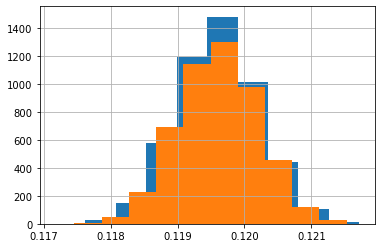

In [7]:
permutation_data["treatment"].hist()
permutation_data["control"].hist()

In [8]:
res = ss.ttest_ind(df2[df2["group"] == 'control']['converted'],
            df2[df2["group"] == 'treatment']['converted'],
            equal_var=True)

print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.0948


In [9]:
four_sessions =  pd.read_csv("/Users/deepjeetdatta/Desktop/four_sessions.csv")

In [10]:
four_sessions


,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [13]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]

In [14]:
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


In [15]:
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

1.986666666666672


In [16]:
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))


Pr(Prob) 0.08866666666666667


In [19]:
import statsmodels.formula.api as smf
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [21]:
res = ss.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


In [23]:
chisq, pvalue, df, expected = ss.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

NameError: name 'clicks' is not defined

In [44]:
clicks_import = pd.read_csv("/Users/deepjeetdatta/Desktop/click_rates.csv")

In [45]:
clicks = clicks_import.pivot(index="Click", columns="Headline", values="Rate")

In [42]:
%xmode Plain

Exception reporting mode: Plain


In [46]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4930
